# Lab Session 7: Word Sequences

In this work the following tasks are performed:
- Use of Spacy Name Entity Recognition modules in order to better identify groups of words that are related to a single entity.

Three main approaches are explored:

- Retokenization of the text using the Spacy NER module.
- Replacement of the words with the entity type.

## Importing libraries

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr
import spacy
nlp = spacy.load("en_core_web_sm")

from nltk.corpus import wordnet as wn
from nltk.stem import PorterStemmer
from nltk import download
download('punkt')
download('averaged_perceptron_tagger')
download('maxent_ne_chunker')
download('words')
download('wordnet')
download('omw-1.4')
import nltk
from nltk.metrics import jaccard_distance

import re
from sklearn.linear_model import RidgeCV

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\alber\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\alber\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\alber\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\alber\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\alber\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\alber\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-d

In [2]:
def jaccard_sim(x, y):
    '''
    Returns the Jaccard similarity between two sets
    '''
    return 1 - jaccard_distance(x, y)

class STSAnalyzer:

    def __init__(self, preprocess_fun, name=None, similarity=jaccard_sim, semantic_fun=None):
        self.preprocess_fun = preprocess_fun
        self.name = name
        self.similarity = similarity
        self.semantic_fun = semantic_fun

    def get_similarity(self, x, y):
        '''
        Get the similarity between two strings
        '''
        if self.semantic_fun is not None:
            x_preprep, y_preprep = self.semantic_fun(x, y)
        else:
            x_preprep, y_preprep = x, y
            
        # Clean the sentences and return a set of words
        x_prep = self.preprocess_fun(x_preprep, out_set=True)
        y_prep = self.preprocess_fun(y_preprep, out_set=True)

        # Return the similarity between the two sets of words
        return self.similarity(x_prep, y_prep)
        
    def corr_with_gold(self, filename):
        '''
        Returns the correlation between the gold standard and the similarity
        Input: filename - string with the name of the file
        Output: Pearson correlation object
        '''

        # In some of the files, tabulations appear as \t instead of a tab
        # To solve this problem, it's been included \\t (escaped "\") as a possible separator
        dt = pd.read_csv('../test-gold/STS.input.' + filename, sep='\t|\\t',
                        header=None, on_bad_lines='skip', engine='python')
        dt['gs'] = pd.read_csv('../test-gold/STS.gs.'+ filename, sep='\t|\\t',header=None, 
                            on_bad_lines='skip', engine='python')
        
        # dt.drop_duplicates(subset = [0, 1], keep=False, inplace = True)

        # Bad lines are inserted as null values sometimes 
        # They are counted, informed and removed
        nulls = dt[dt.isnull().any(axis=1)]
        if len(nulls) > 0:
            print(filename, '\n', nulls)
            dt = dt.dropna()

        # Get the similarity between the two sentences
        arr_sim = dt.apply(lambda x: self.get_similarity(*x[:2]) , axis=1).values
        
        return pearsonr(arr_sim, dt['gs'].values)

    def ind_report(self, file, n_show=10):

        print("=====================================================")
        print(file)
        print("=====================================================")
        print("\n")
        df_ind_report = pd.read_csv(f'../test-gold/STS.input.{file}',sep='\t|\\t',header=None, engine='python')
        # df_ind_report.drop_duplicates(subset = [0, 1], keep=False, inplace = True)
        df_ind_report['gs'] = pd.read_csv(f'../test-gold/STS.gs.{file}',sep='\t|\\t',header=None, engine='python')
        df_ind_report['sim'] = df_ind_report.apply(lambda x: self.get_similarity(*x[:2]) , axis=1)
        df_ind_report['sim'] *= 5.
        df_ind_report['dif'] = df_ind_report['sim'] - df_ind_report['gs']

        if n_show is not None:
            difs_tail = df_ind_report.sort_values(by='dif', ascending=False).tail(n_show)
        else:
            difs_tail = df_ind_report.sort_values(by='dif', ascending=False)
            
        for idx, row in difs_tail.iterrows():
            x, y = row[0], row[1]
            prep_x, prep_y = self.preprocess_fun(x, out_set=True), self.preprocess_fun(y, out_set=True)
            print(f"RAW TEXT (DIFFERENCE {row['dif']:.2f})")
            print(x, '\n', y)
            print("\nPREPROCESSED TEXT")
            print(prep_x, '\n', prep_y)
            print("INTERSECTION", prep_x.intersection(prep_y))
            print("DIFFERENCE", prep_x.difference(prep_y).union(prep_y.difference(prep_x)))
            print('\n\n')

            if self.semantic_fun is not None:
                print("SEMANTICAL MODIFICATION\n")
                x, y = self.semantic_fun(row[0], row[1])
                prep_x, prep_y = self.preprocess_fun(x, out_set=True), self.preprocess_fun(y, out_set=True)
                print(f"RAW TEXT (DIFFERENCE {row['dif']:.2f})")
                print(x, '\n', y)
                print("\nPREPROCESSED TEXT")
                print(prep_x, '\n', prep_y)
                print("INTERSECTION", prep_x.intersection(prep_y))
                print("DIFFERENCE", prep_x.difference(prep_y).union(prep_y.difference(prep_x)))
                print('\n\n')

        fig, ax = plt.subplots(1, 2, figsize=(10,2.5))
        plt.suptitle(file)
        df_ind_report.dif.plot.hist(bins=20, title="Residuals", ax=ax[0])
        df_ind_report.dif.plot.box(title="Residuals", ax=ax[1]);
        
        self.df_ind_report = df_ind_report

    def corr_table(self, ls_files):
        
        df_scores = pd.DataFrame(columns=['file','pearson','p_value', 'conf_low', 'conf_high'])

        ls_corr = []
        ls_p_value = []
        ls_conf_low, ls_conf_high = [], []

        for file in ls_files:
            print(f"Processing {file}")
            pearson_stats = self.corr_with_gold(file)
            ls_corr.append(pearson_stats.statistic)
            ls_p_value.append(pearson_stats.pvalue)
            ls_conf_low.append(pearson_stats.confidence_interval(.95).low)
            ls_conf_high.append(pearson_stats.confidence_interval(.95).high)

        df_scores['file'] = ls_files
        df_scores['pearson'] = ls_corr
        df_scores['p_value'] = ls_p_value
        df_scores['conf_low'] = ls_conf_low
        df_scores['conf_high'] = ls_conf_high
        
        if self.name is not None:
            df_scores['name'] = self.name

        self.df_scores = df_scores
        return df_scores
    
    def col_report(self, ls_files, n_show=10):

        # pool = mp.Pool(processes=len(ls_files))  # Use all available CPU cores

        # # Use the pool to parallelize the execution of self.ind_report for each file
        # results = pool.map(self.ind_report, ls_files)

        # # Close the pool and wait for all processes to finish
        # pool.close()
        # pool.join()
        # print(results)
        # # Concatenate the results into a single DataFrame
        # df_col_analysis = pd.DataFrame()
        # for file, df_ind in zip(ls_files, results):
        #     df_ind['file'] = file
        #     df_col_analysis = pd.concat([df_col_analysis, df_ind], axis=0)

        df_col_analysis = pd.DataFrame()
        for file in ls_files:
            self.ind_report(file, n_show=n_show)
            df_ind = self.df_ind_report
            df_ind['file'] = file
            df_col_analysis = pd.concat([df_col_analysis, df_ind], axis=0)
        
        # Pearson correlation for the concatenation of all five datasets
        self.total_corr = pearsonr(df_col_analysis['sim'].values, df_col_analysis['gs'].values)

        # Autoscaled correlation (ALLNORM)
        reg = RidgeCV(alphas=np.logspace(-6, 6, 13), cv=3)
        arr_preds = np.concatenate(df_col_analysis.groupby('file').\
                                    apply(lambda x: reg.fit(x.sim.values.reshape(-1, 1), x.gs.values).predict(x.sim.values.reshape(-1, 1))).values)
        self.allnorm = pearsonr(arr_preds, df_col_analysis['gs'].values)
        
        # Weighted mean correlation (WMEAN)
        self.w_mean = df_col_analysis.groupby('file').\
                        apply(lambda x: pearsonr(x.sim.values, x.gs.values).statistic * x.shape[0] / df_col_analysis.shape[0]).sum()
        
        # Weighted mean of the Pearson correlations on individual datasets
        df_global_scores = pd.DataFrame(columns=['all', 'allnorm', 'wmean'])
        df_global_scores.loc[0] = [self.total_corr[0], self.allnorm[0], self.w_mean]
        if self.name is not None:
            df_global_scores['name'] = self.name
        self.df_global_scores = df_global_scores

        self.df_col_analysis = df_col_analysis

        return df_global_scores
    
    def plot_col_analysis(self, ls_sts=[]):
        df_scores_comp = self.df_scores.copy()
        df_global_scores_comp = self.df_global_scores.copy()

        if ls_sts != []:
            for sts in ls_sts:
                df_scores_comp = pd.concat([df_scores_comp, sts.df_scores], 
                                             axis=0, ignore_index=True)
                df_global_scores_comp = pd.concat([df_global_scores_comp, sts.df_global_scores],
                                                     axis=0, ignore_index=True)
                
        plt.figure(figsize=(10,5))
        sns.barplot(x='file', y='pearson', hue='name', data=df_scores_comp)
        plt.title('Pearson correlation between similarity and gold standard for different preprocessings')
        plt.xticks(rotation=45)

        df_global_comp_plot = df_global_scores_comp.melt(id_vars='name', value_vars=['all', 'allnorm', 'wmean'])
        plt.figure(figsize=(10,5))
        sns.lineplot(x="variable", y="value", hue="name", data=df_global_comp_plot, marker='o')
        plt.ylim(0.5, 1.);
        
                        

# Introduction to Spacy NER

In the following cell, an example on how to retokenize a text using NER is shown. The function `retokenize` takes a text and returns a list of tokens. The function `retokenize_ner` takes a text and returns a list of tokens, where the named entities are replaced by their type.

### Spacy

spaCy's NER model is based on a machine learning algorithm known as a conditional random field (CRF)

In [8]:
sent = "Spanish Government had a meeting with the French Government at 3pm in Madrid."
doc = nlp(sent)


with doc.retokenize() as retokenizer:
    tokens = [token for token in doc]
    for ent in doc.ents:
        retokenizer.merge(doc[ent.start:ent.end], 
            attrs={"LEMMA": " ".join([tokens[i].text 
                                for i in range(ent.start, ent.end)])})

[(token.text, token.pos_, token.tag_, token.lemma_, token.is_stop, 
  token.ent_iob_, token.ent_type_) for token in doc]

spacy.displacy.render(doc, jupyter=True, style='ent')

### NLTK

NLTKs algorithm is based on a Maximum Entropy Markov Model (MEMM). The model is trained on the CoNLL 2003 corpus.

It works worse than spacy in most of the cases.

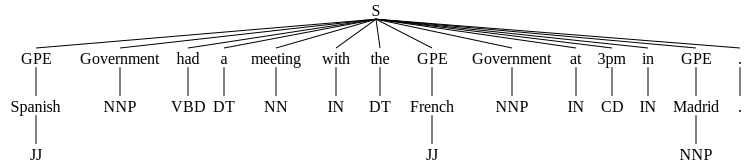

In [15]:
sent = "Spanish Government had a meeting with the French Government at 3pm in Madrid."
res = nltk.ne_chunk(
        nltk.pos_tag(
          nltk.word_tokenize(sent)))

res

### TextServer

In [28]:
from textserver import TextServer

ts = TextServer('alberto.becerra', 'patata123.', 'entities')
ts.entities(sent)

[[['Spanish_Government',
   'spanish_government',
   'NP00V00',
   'noun',
   'N/A',
   'other'],
  ['had', 'have', 'VBD', 'verb', '00065639-v', 'N/A'],
  ['a', 'a', 'DT', 'determiner', 'N/A', 'N/A'],
  ['meeting', 'meeting', 'NN', 'noun', '08307589-n', 'N/A'],
  ['with', 'with', 'IN', 'preposition', 'N/A', 'N/A'],
  ['the', 'the', 'DT', 'determiner', 'N/A', 'N/A'],
  ['French', 'french', 'NP00V00', 'noun', '06964901-n', 'other'],
  ['Government', 'government', 'NN', 'noun', '05663671-n', 'N/A'],
  ['at', 'at', 'IN', 'preposition', 'N/A', 'N/A'],
  ['3pm', '3pm', 'Z', 'number', 'N/A', 'N/A'],
  ['in', 'in', 'IN', 'preposition', 'N/A', 'N/A'],
  ['Madrid', 'madrid', 'NP00G00', 'noun', '09024467-n', 'location'],
  ['.', '.', 'Fp', 'punctuation', 'N/A', 'N/A']]]

# Baseline: Lemmatization and Porter Stemmer

All the results of our analysisare going to be compared with the best performing model until now, which is the one that uses lemmatization and Porter Stemmer.

MSRpar.txt


RAW TEXT (DIFFERENCE -3.64)
Sendmail said the system can even be set up to permit business-only usage. 
 The product can be instructed to permit business-only use, according to Sendmail.

PREPROCESSED TEXT
{'say', 'sendmail', 'usag', 'busi', 'system', 'set', 'permit'} 
 {'product', 'sendmail', 'busi', 'accord', 'use', 'instruct', 'permit'}
INTERSECTION {'sendmail', 'busi', 'permit'}
DIFFERENCE {'product', 'say', 'usag', 'accord', 'system', 'set', 'use', 'instruct'}



MSRvid.txt


RAW TEXT (DIFFERENCE -4.00)
A band is performing on a stage. 
 A band is playing onstage.

PREPROCESSED TEXT
{'band', 'stage', 'perform'} 
 {'band', 'onstag', 'play'}
INTERSECTION {'band'}
DIFFERENCE {'stage', 'play', 'onstag', 'perform'}



SMTeuroparl.txt


RAW TEXT (DIFFERENCE -4.50)
There must be a balance as a whole. 
 Group must be in equilibrium.

PREPROCESSED TEXT
{'balanc'} 
 {'equilibrium', 'group'}
INTERSECTION set()
DIFFERENCE {'equilibrium', 'balanc', 'group'}



surprise.OnWN.txt




,file,pearson,p_value,conf_low,conf_high,name
0,MSRpar.txt,0.595611,3.362127e-73,0.547361,0.639914,Lemma+Porter+Clean
1,MSRvid.txt,0.786032,2.117405e-158,0.757043,0.811933,Lemma+Porter+Clean
2,SMTeuroparl.txt,0.525436,6.132524e-34,0.455831,0.588654,Lemma+Porter+Clean
3,surprise.OnWN.txt,0.651277,1.005897e-91,0.608038,0.690664,Lemma+Porter+Clean
4,surprise.SMTnews.txt,0.409572,1.429425e-17,0.324443,0.488120,Lemma+Porter+Clean


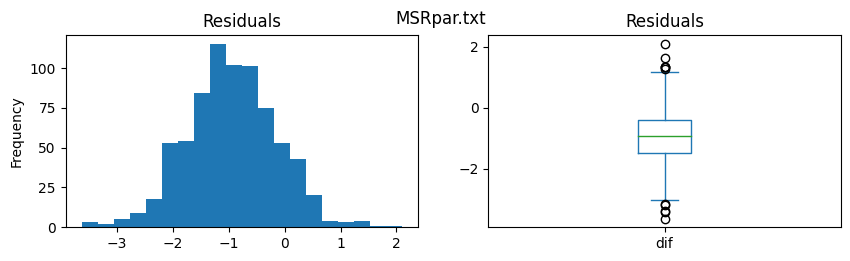

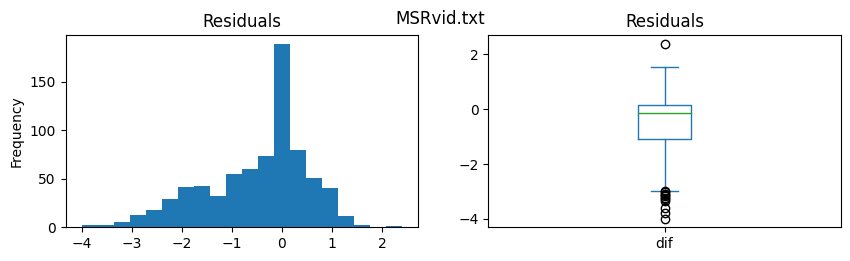

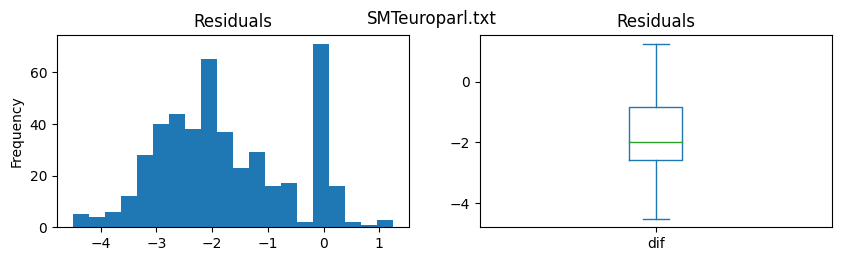

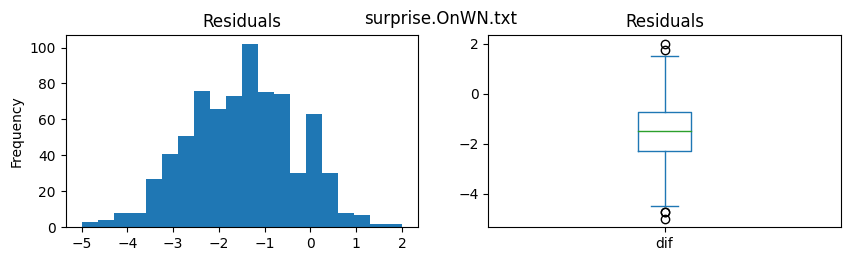

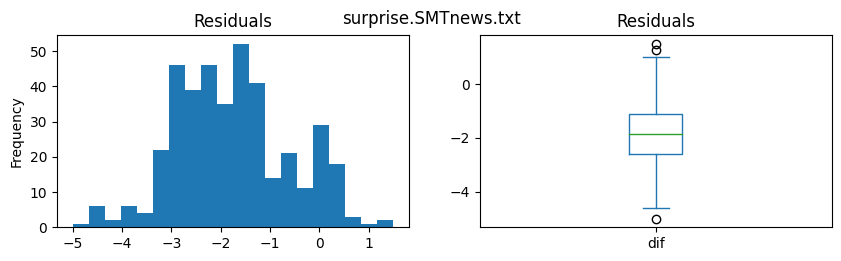

In [3]:
def clean_text(text):

    # Standardize the hours (1pm -> 13:00)
    def convert_to_24_hour(match):
        '''
        Function to convert time to 24 hour format
        Input: match - match object
        Output: string with the time in 24 hour format
        '''
        time_str = match.groups()
        hour, minute, am_pm = time_str[0], '' if time_str[1] is None else time_str[1] ,  re.sub('\.', '', '' if time_str[2] is None else time_str[2])
        # print(time_str)
        if am_pm == 'pm':
            if minute == '':
                return str(int(hour) + 12) + ':00'
            else:
                return str(int(hour) + 12) + ':' + minute
        elif am_pm == 'am':
            if hour == '12':
                return "00" + ':' + minute
            elif minute == '':
                return hour + ':00'
            else:
                return hour + ':' + minute
        else:
            if minute == '':
                return hour + ':00'
            else:
                return hour + ':' + minute

    hour_pattern_1 = re.compile(r'(?<=\s)(\d+)\s?()([ap]\.?m\.?)')
    hour_pattern_2 = re.compile(r'(\d+)[:\.](\d+)\s?([ap]\.?m\.?)')
    hour_pattern_3 = re.compile(r'(\d+)\s?[h:]\s?(\d+)\s?([ap]\.?m\.?)?')
    ls_patterns = [hour_pattern_1, hour_pattern_2, hour_pattern_3]
    for pat in ls_patterns:
        text = re.sub(pat, convert_to_24_hour, text)

    # Delete rests of abbreviated particles
    particle_pattern = re.compile(r"\b(?:'s|'d|'ll|'m|'re|'ve)\b", re.IGNORECASE)
    formatted_text = re.sub(particle_pattern, '', text)

    # Delete rests of abbreviated words to refer people
    mr_ms_pattern = re.compile(r"\b(mr.|mr|ms|ms.|mss.)\b", re.IGNORECASE)
    formatted_text = re.sub(mr_ms_pattern, '', formatted_text)

    # Convert indexes to a single word
    idx_pattern = re.compile(r'<\W*(\w+)=*(\w*)>', re.IGNORECASE)
    formatted_text = re.sub(idx_pattern, r'\1\2', formatted_text)
    
    # Remove the point from words starting with it
    start_point_pattern = re.compile(r'(\W)\.(\w+)', re.IGNORECASE)
    formatted_text = re.sub(start_point_pattern, r'\2', formatted_text)

    # Remove the comma from thousands (standardize)
    thousands_pattern = re.compile(r'(\d+),(\d+)', re.IGNORECASE)
    formatted_text = re.sub(thousands_pattern, r'\1\2', formatted_text)

    # Transform percentages to a single word
    percent_pattern = re.compile(r'(\d+)\s*per\s*cent', re.IGNORECASE)
    formatted_text = re.sub(percent_pattern, r'\1_%', formatted_text)
    
    # Remove the dollar sign from money
    money_pattern = re.compile(r'\$', re.IGNORECASE)
    formatted_text = re.sub(money_pattern, '' , formatted_text)

    return formatted_text

def spacy_preprocess_reviews(text, sw_lang='english', out_set=False, clean_func=None):
    '''
    Function to preprocess the text - remove punctuations, convert to lowercase, remove stopwords
    Input: text - string
    Output: ls_processed_text - list of words
    '''
    if clean_func is not None:
        text = clean_func(text)

    doc = nlp(text)
    ls_processed_text = [w.text.lower() for w in doc if not w.is_stop and not w.is_punct]
    if out_set:
        # For distance metrics, usually, it's needed a set of words
        return set(ls_processed_text)
    else:
        return ls_processed_text

def spacy_preprocess_lemma_porter(text, sw_lang='english', out_set=False, clean_func=None):
    '''
    Function to preprocess the text - remove punctuations, convert to lowercase, remove stopwords
    Input: text - string
    Output: ls_processed_text - list of words
    '''

    if clean_func is not None:
        text = clean_func(text)
    # text = clean_text(text)
    doc = nlp(text)
    stemmer = PorterStemmer()
    ls_processed_text = [stemmer.stem(w.lemma_.lower()) for w in doc if not w.is_stop and not w.is_punct]

    if out_set:
        # For distance metrics, usually, it's needed a set of words
        return set(ls_processed_text)
    else:
        return ls_processed_text
    
def spacy_preprocess_lemma_porter_clean(x, **kwargs): return spacy_preprocess_lemma_porter(x, clean_func=clean_text, **kwargs)

ls_files = ["MSRpar.txt", "MSRvid.txt", "SMTeuroparl.txt", "surprise.OnWN.txt", "surprise.SMTnews.txt"]

lemma_porter_clean = STSAnalyzer(spacy_preprocess_lemma_porter_clean, name='Lemma+Porter+Clean')
lemma_porter_clean.col_report(ls_files, n_show=1)
lemma_porter_clean.corr_table(ls_files)

In [4]:
lemma_porter_clean.df_global_scores

,all,allnorm,wmean,name
0,0.631572,0.816485,0.620748,Lemma+Porter+Clean


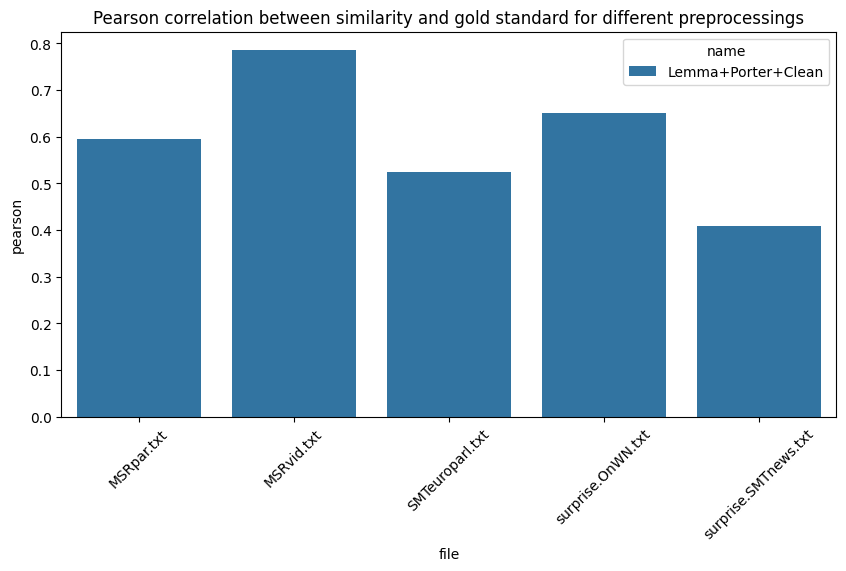

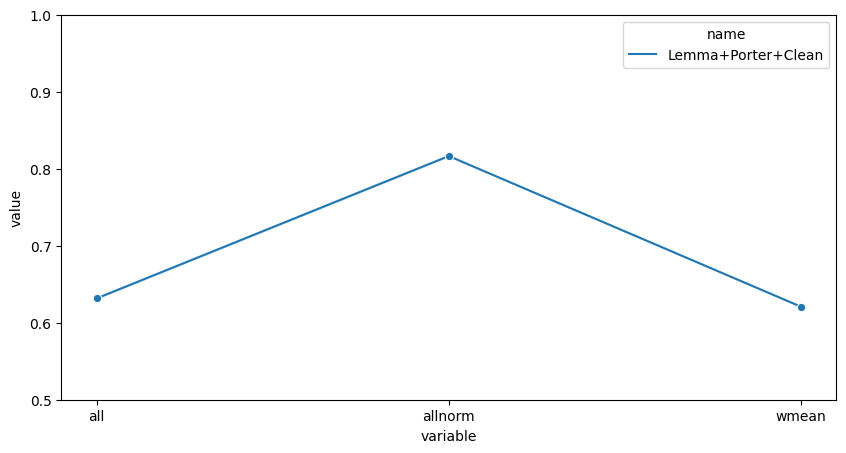

In [5]:
lemma_porter_clean.plot_col_analysis([lemma_porter_clean])

# Introduce NER based Tokenization

MSRpar.txt


RAW TEXT (DIFFERENCE -2.97)
The problem likely will mean corrective changes before the shuttle fleet starts flying again. 
 He said the problem needs to be corrected before the space shuttle fleet is cleared to fly again.

PREPROCESSED TEXT
{'shuttle', 'change', 'problem', 'fleet', 'corrective', 'mean', 'start', 'fly', 'likely'} 
 {'shuttle', 'space', 'say', 'correct', 'need', 'problem', 'fleet', 'clear', 'fly'}
INTERSECTION {'fleet', 'shuttle', 'fly', 'problem'}
DIFFERENCE {'space', 'say', 'change', 'correct', 'need', 'clear', 'corrective', 'mean', 'start', 'likely'}



RAW TEXT (DIFFERENCE -3.00)
The trial, featuring 125 witnesses, could continue until the start of 2004. 
 The trial, which could last until early 2004, is expected to hear the first of 125 witnesses Friday.

PREPROCESSED TEXT
{'125', 'trial', 'the start of 2004', 'feature', 'continue', 'witness'} 
 {'expect', '125', 'hear', 'trial', 'friday', 'early 2004', 'witness'}
INTERSECTION {'125', 'witness', 'trial'

,file,pearson,p_value,conf_low,conf_high,name
0,MSRpar.txt,0.564570,2.350443e-64,0.513745,0.611446,Lemma+NER+Clean
1,MSRvid.txt,0.768851,2.046299e-147,0.737875,0.796594,Lemma+NER+Clean
2,SMTeuroparl.txt,0.486392,1.240420e-28,0.413263,0.553288,Lemma+NER+Clean
3,surprise.OnWN.txt,0.614001,6.530212e-79,0.567351,0.656723,Lemma+NER+Clean
4,surprise.SMTnews.txt,0.384143,1.769684e-15,0.297176,0.464789,Lemma+NER+Clean


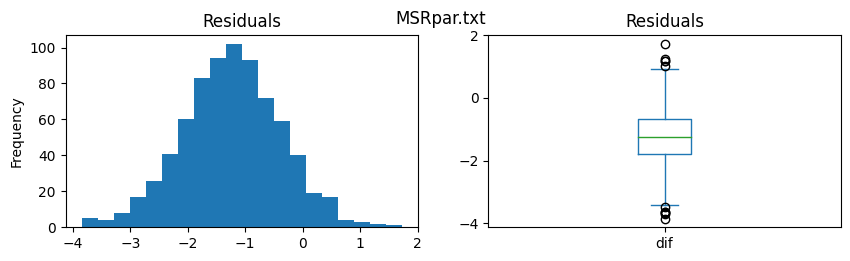

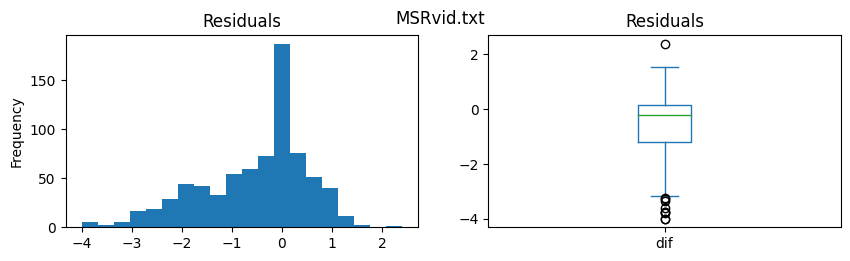

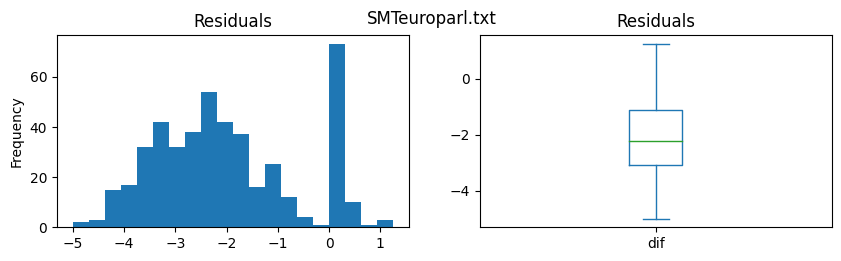

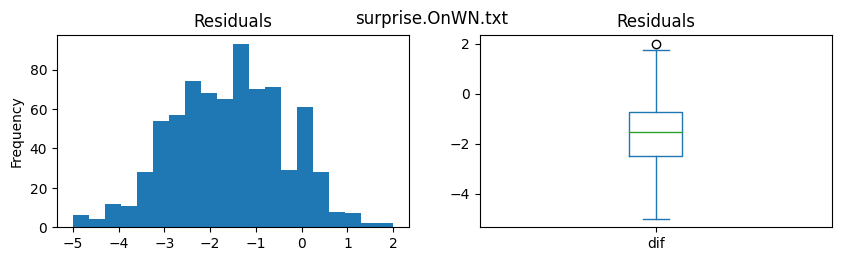

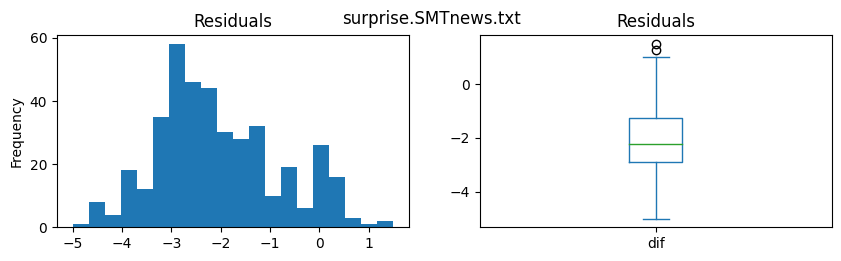

In [6]:
def clean_text(text):

    # Standardize the hours (1pm -> 13:00)
    def convert_to_24_hour(match):
        '''
        Function to convert time to 24 hour format
        Input: match - match object
        Output: string with the time in 24 hour format
        '''
        time_str = match.groups()
        hour, minute, am_pm = time_str[0], '' if time_str[1] is None else time_str[1] ,  re.sub('\.', '', '' if time_str[2] is None else time_str[2])
        # print(time_str)
        if am_pm == 'pm':
            if minute == '':
                return str(int(hour) + 12) + ':00'
            else:
                return str(int(hour) + 12) + ':' + minute
        elif am_pm == 'am':
            if hour == '12':
                return "00" + ':' + minute
            elif minute == '':
                return hour + ':00'
            else:
                return hour + ':' + minute
        else:
            if minute == '':
                return hour + ':00'
            else:
                return hour + ':' + minute

    hour_pattern_1 = re.compile(r'(?<=\s)(\d+)\s?()([ap]\.?m\.?)')
    hour_pattern_2 = re.compile(r'(\d+)[:\.](\d+)\s?([ap]\.?m\.?)')
    hour_pattern_3 = re.compile(r'(\d+)\s?[h:]\s?(\d+)\s?([ap]\.?m\.?)?')
    ls_patterns = [hour_pattern_1, hour_pattern_2, hour_pattern_3]
    for pat in ls_patterns:
        text = re.sub(pat, convert_to_24_hour, text)

    # Delete rests of abbreviated particles
    particle_pattern = re.compile(r"\b(?:'s|'d|'ll|'m|'re|'ve)\b", re.IGNORECASE)
    formatted_text = re.sub(particle_pattern, '', text)

    # Delete rests of abbreviated words to refer people
    mr_ms_pattern = re.compile(r"\b(mr.|mr|ms|ms.|mss.)\b", re.IGNORECASE)
    formatted_text = re.sub(mr_ms_pattern, '', formatted_text)

    # Convert indexes to a single word
    idx_pattern = re.compile(r'<\W*(\w+)=*(\w*)>', re.IGNORECASE)
    formatted_text = re.sub(idx_pattern, r'\1\2', formatted_text)
    
    # Remove the point from words starting with it
    start_point_pattern = re.compile(r'(\W)\.(\w+)', re.IGNORECASE)
    formatted_text = re.sub(start_point_pattern, r'\2', formatted_text)

    # Remove the comma from thousands (standardize)
    thousands_pattern = re.compile(r'(\d+),(\d+)', re.IGNORECASE)
    formatted_text = re.sub(thousands_pattern, r'\1\2', formatted_text)

    # Transform percentages to a single word
    percent_pattern = re.compile(r'(\d+)\s*per\s*cent', re.IGNORECASE)
    formatted_text = re.sub(percent_pattern, r'\1_%', formatted_text)
    
    # Remove the dollar sign from money
    money_pattern = re.compile(r'\$', re.IGNORECASE)
    formatted_text = re.sub(money_pattern, '' , formatted_text)

    return formatted_text


def spacy_ner(text, sw_lang='english', out_set=False, clean_func=None):
    '''
    Function to preprocess the text - remove punctuations, convert to lowercase, remove stopwords
    Input: text - string
    Output: ls_processed_text - list of words
    '''

    if clean_func is not None:
        text = clean_func(text)

    # text = clean_text(text)
    doc = nlp(text)
    with doc.retokenize() as retokenizer:
        tokens = [token for token in doc]
        for ent in doc.ents:
            retokenizer.merge(doc[ent.start:ent.end], 
                attrs={"LEMMA": " ".join([tokens[i].text 
                                    for i in range(ent.start, ent.end)])})

    ls_processed_text = [w.lemma_.lower() for w in doc if not w.is_stop and not w.is_punct]

    if out_set:
        # For distance metrics, usually, it's needed a set of words
        return set(ls_processed_text)
    else:
        return ls_processed_text
    
def spacy_ner_clean(x, **kwargs): return spacy_ner(x, clean_func=clean_text, **kwargs)

ls_files = ["MSRpar.txt", "MSRvid.txt", "SMTeuroparl.txt", "surprise.OnWN.txt", "surprise.SMTnews.txt"]

lemma_ner_clean = STSAnalyzer(spacy_ner_clean, name='Lemma+NER+Clean')
lemma_ner_clean.col_report(ls_files, n_show=20)
lemma_ner_clean.corr_table(ls_files)

In [7]:
lemma_ner_clean.df_global_scores

,all,allnorm,wmean,name
0,0.576005,0.803465,0.591085,Lemma+NER+Clean


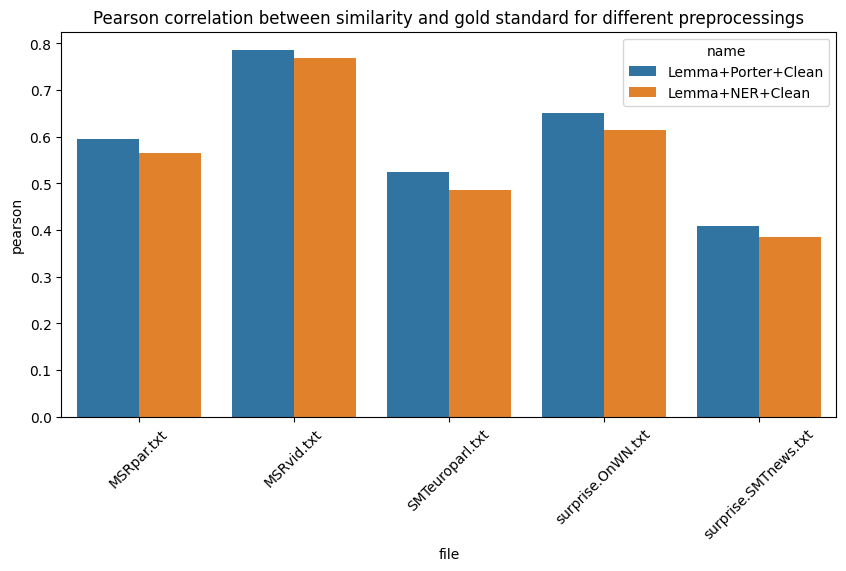

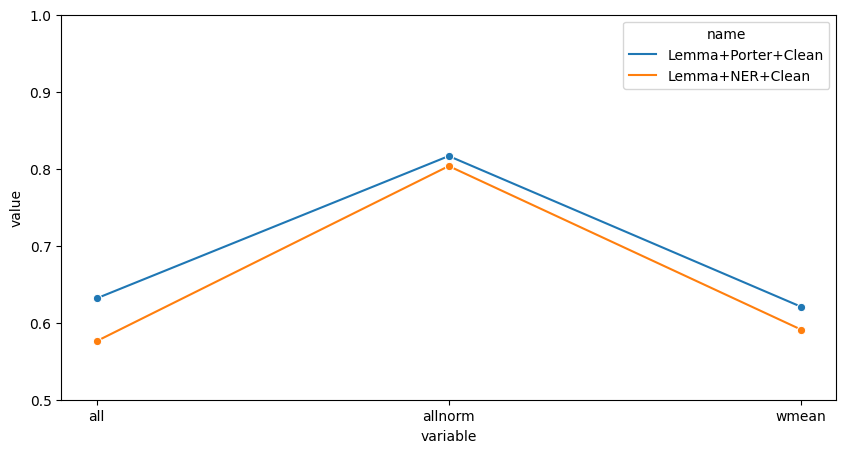

In [8]:
lemma_porter_clean.plot_col_analysis([lemma_ner_clean])

# NER Based Tokenization and Replace by NER label

MSRpar.txt


RAW TEXT (DIFFERENCE -2.90)
Officials at Brandeis said this was an "extremely heartrending" time for the campus. 
 "This is an extremely heartrending time for the entire Brandeis University community.

PREPROCESSED TEXT
{'extremely', 'official', 'time', 'say', 'brandeis', 'heartrending', 'campus'} 
 {'ORG', 'time', 'extremely', 'heartrending', 'entire', 'community'}
INTERSECTION {'extremely', 'time', 'heartrending'}
DIFFERENCE {'ORG', 'brandeis', 'official', 'community', 'campus', 'say', 'entire'}



RAW TEXT (DIFFERENCE -2.92)
In turn SuSE will license Java 2 Standard Edition while also formalising an existing agreement to distribute Sun's Java Virtual Machine for running Java applications. 
 Nuremberg, Germany-based SuSE will license Sun's Java 2 Standard Edition (J2SE) and ship Sun's Java Virtual Machine across its Linux software line.

PREPROCESSED TEXT
{'exist', 'suse', 'java', 'run', 'formalise', 'license', 'PERSON', 'turn', 'distribute', 'agreement', 'ORG', 'applica

,file,pearson,p_value,conf_low,conf_high,name
0,MSRpar.txt,0.525426,1.856491e-54,0.471576,0.575373,Lemma+NER+Replace+Clean
1,MSRvid.txt,0.768851,2.046299e-147,0.737875,0.796594,Lemma+NER+Replace+Clean
2,SMTeuroparl.txt,0.498481,3.335982e-30,0.426409,0.564264,Lemma+NER+Replace+Clean
3,surprise.OnWN.txt,0.616425,1.080853e-79,0.569990,0.658936,Lemma+NER+Replace+Clean
4,surprise.SMTnews.txt,0.383645,1.936891e-15,0.296643,0.464331,Lemma+NER+Replace+Clean


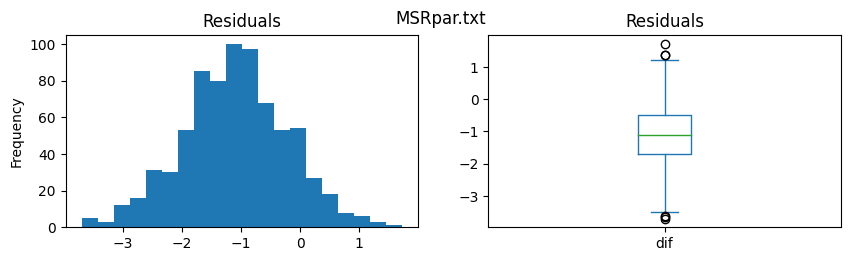

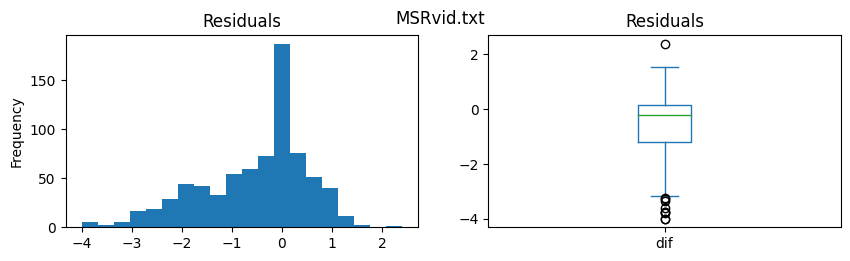

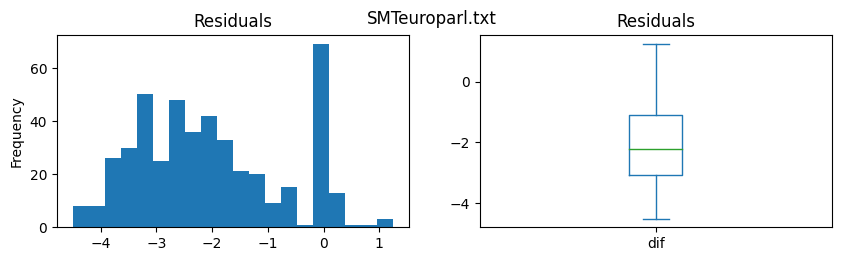

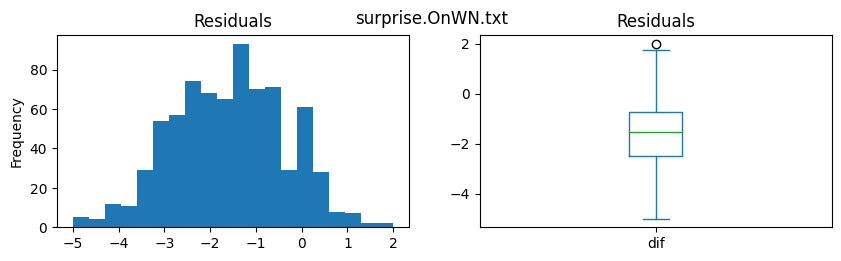

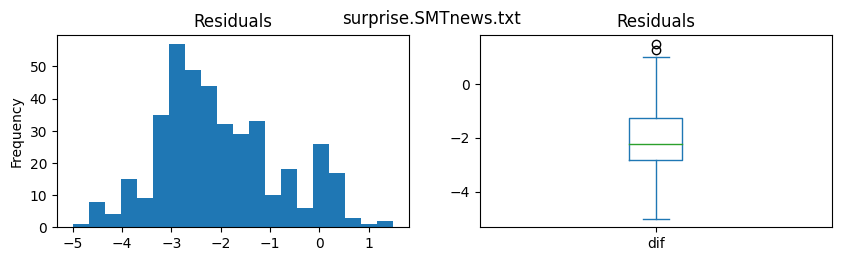

In [9]:
def clean_text(text):

    # Standardize the hours (1pm -> 13:00)
    def convert_to_24_hour(match):
        '''
        Function to convert time to 24 hour format
        Input: match - match object
        Output: string with the time in 24 hour format
        '''
        time_str = match.groups()
        hour, minute, am_pm = time_str[0], '' if time_str[1] is None else time_str[1] ,  re.sub('\.', '', '' if time_str[2] is None else time_str[2])
        # print(time_str)
        if am_pm == 'pm':
            if minute == '':
                return str(int(hour) + 12) + ':00'
            else:
                return str(int(hour) + 12) + ':' + minute
        elif am_pm == 'am':
            if hour == '12':
                return "00" + ':' + minute
            elif minute == '':
                return hour + ':00'
            else:
                return hour + ':' + minute
        else:
            if minute == '':
                return hour + ':00'
            else:
                return hour + ':' + minute

    hour_pattern_1 = re.compile(r'(?<=\s)(\d+)\s?()([ap]\.?m\.?)')
    hour_pattern_2 = re.compile(r'(\d+)[:\.](\d+)\s?([ap]\.?m\.?)')
    hour_pattern_3 = re.compile(r'(\d+)\s?[h:]\s?(\d+)\s?([ap]\.?m\.?)?')
    ls_patterns = [hour_pattern_1, hour_pattern_2, hour_pattern_3]
    for pat in ls_patterns:
        text = re.sub(pat, convert_to_24_hour, text)

    # Delete rests of abbreviated particles
    particle_pattern = re.compile(r"\b(?:'s|'d|'ll|'m|'re|'ve)\b", re.IGNORECASE)
    formatted_text = re.sub(particle_pattern, '', text)

    # Delete rests of abbreviated words to refer people
    mr_ms_pattern = re.compile(r"\b(mr.|mr|ms|ms.|mss.)\b", re.IGNORECASE)
    formatted_text = re.sub(mr_ms_pattern, '', formatted_text)

    # Convert indexes to a single word
    idx_pattern = re.compile(r'<\W*(\w+)=*(\w*)>', re.IGNORECASE)
    formatted_text = re.sub(idx_pattern, r'\1\2', formatted_text)
    
    # Remove the point from words starting with it
    start_point_pattern = re.compile(r'(\W)\.(\w+)', re.IGNORECASE)
    formatted_text = re.sub(start_point_pattern, r'\2', formatted_text)

    # Remove the comma from thousands (standardize)
    thousands_pattern = re.compile(r'(\d+),(\d+)', re.IGNORECASE)
    formatted_text = re.sub(thousands_pattern, r'\1\2', formatted_text)

    # Transform percentages to a single word
    percent_pattern = re.compile(r'(\d+)\s*per\s*cent', re.IGNORECASE)
    formatted_text = re.sub(percent_pattern, r'\1_%', formatted_text)
    
    # Remove the dollar sign from money
    money_pattern = re.compile(r'\$', re.IGNORECASE)
    formatted_text = re.sub(money_pattern, '' , formatted_text)

    return formatted_text


def spacy_ner_replace(text, sw_lang='english', out_set=False, clean_func=None):
    '''
    Function to preprocess the text - remove punctuations, convert to lowercase, remove stopwords
    Input: text - string
    Output: ls_processed_text - list of words
    '''

    if clean_func is not None:
        text = clean_func(text)

    # text = clean_text(text)
    doc = nlp(text)
    with doc.retokenize() as retokenizer:
        tokens = [token for token in doc]
        for ent in doc.ents:
            retokenizer.merge(doc[ent.start:ent.end], 
                attrs={"LEMMA": " ".join([tokens[i].text 
                                    for i in range(ent.start, ent.end)])})

    ls_processed_text = [w.lemma_.lower() if len(w.text.split()) == 1 else w.ent_type_ 
                         for w in doc if not w.is_stop and not w.is_punct]

    if out_set:
        # For distance metrics, usually, it's needed a set of words
        return set(ls_processed_text)
    else:
        return ls_processed_text
    
def spacy_ner_replace_clean(x, **kwargs): return spacy_ner_replace(x, clean_func=clean_text, **kwargs)

ls_files = ["MSRpar.txt", "MSRvid.txt", "SMTeuroparl.txt", "surprise.OnWN.txt", "surprise.SMTnews.txt"]

lemma_ner_replace_clean = STSAnalyzer(spacy_ner_replace_clean, name='Lemma+NER+Replace+Clean')
lemma_ner_replace_clean.col_report(ls_files, n_show=20)
lemma_ner_replace_clean.corr_table(ls_files)

In [10]:
lemma_ner_replace_clean.df_global_scores

,all,allnorm,wmean,name
0,0.575486,0.800897,0.583946,Lemma+NER+Replace+Clean


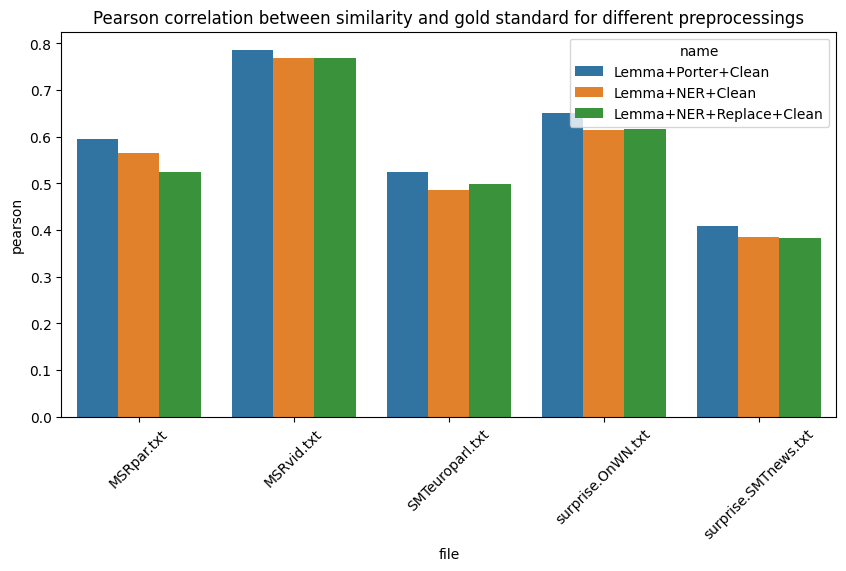

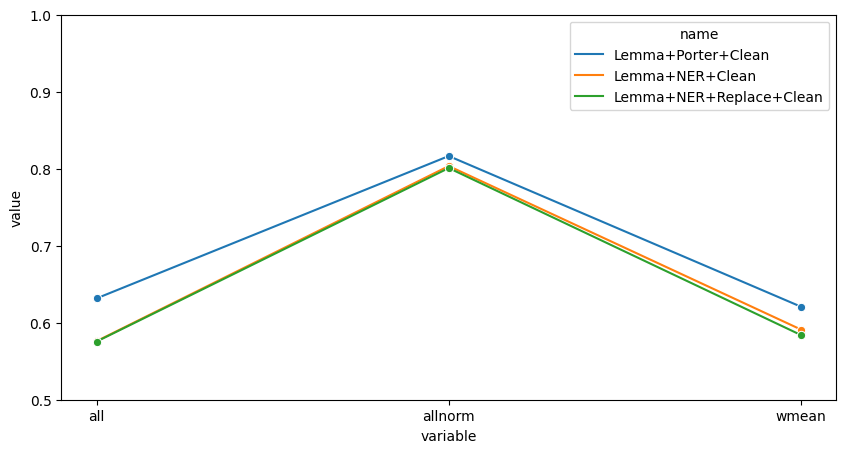

In [11]:
lemma_porter_clean.plot_col_analysis([lemma_ner_clean, lemma_ner_replace_clean])

# NER Based Tokenization and Replace by NER label and Porter Stemming

MSRpar.txt


RAW TEXT (DIFFERENCE -2.84)
The Cradle of Liberty Council isn't the first one to buck the national group's stance. 
 Philadelphia's council is not the first to defy the national policy.

PREPROCESSED TEXT
{'buck', 'group', 'nation', 'ORG', 'stanc'} 
 {'philadelphia', 'defi', 'council', 'nation', 'polici'}
INTERSECTION {'nation'}
DIFFERENCE {'philadelphia', 'buck', 'defi', 'council', 'group', 'ORG', 'stanc', 'polici'}



RAW TEXT (DIFFERENCE -2.88)
The government has chosen three companies to develop plans to protect commercial aircraft from shoulder-fired missile attacks, homeland security officials announced Tuesday. 
 The Department of Homeland Security announced Tuesday that it has selected three companies to continue research into ways to thwart shoulder-fired missile attacks on U.S. commercial aircraft.

PREPROCESSED TEXT
{'develop', 'homeland', 'fire', 'choos', 'protect', 'plan', 'commerci', 'compani', 'shoulder', 'attack', 'offici', 'missil', 'govern', 'announc', 's

,file,pearson,p_value,conf_low,conf_high,name
0,MSRpar.txt,0.528364,3.718062e-55,0.474732,0.578086,Lemma+NER+Replace+Porter+Clean
1,MSRvid.txt,0.785424,5.395512e-158,0.756364,0.811390,Lemma+NER+Replace+Porter+Clean
2,SMTeuroparl.txt,0.476598,2.092815e-27,0.402635,0.544378,Lemma+NER+Replace+Porter+Clean
3,surprise.OnWN.txt,0.643041,9.717771e-89,0.599028,0.683180,Lemma+NER+Replace+Porter+Clean
4,surprise.SMTnews.txt,0.392599,3.731775e-16,0.306227,0.472560,Lemma+NER+Replace+Porter+Clean


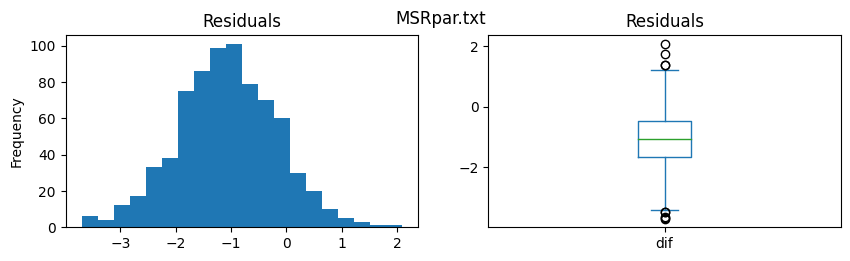

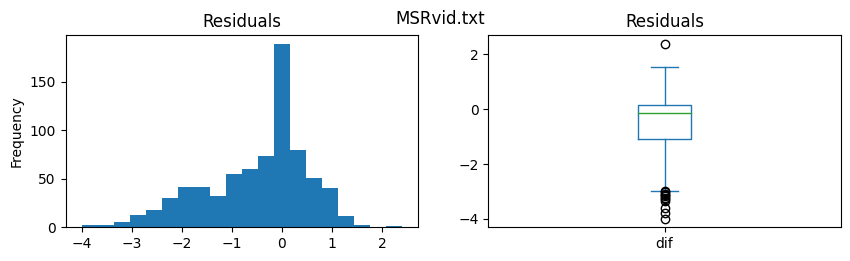

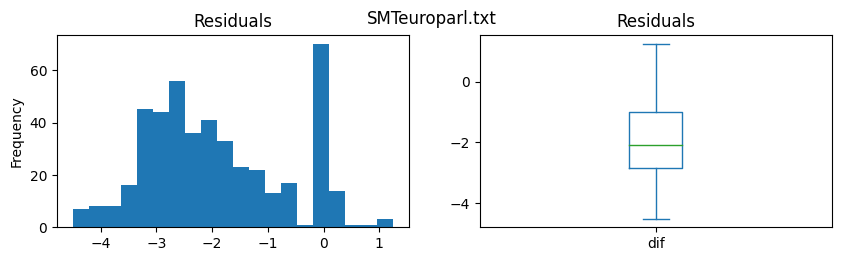

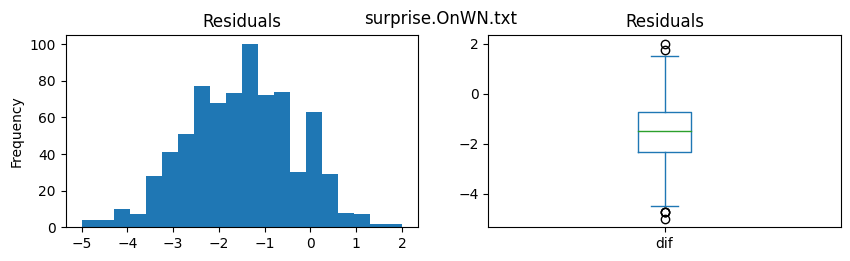

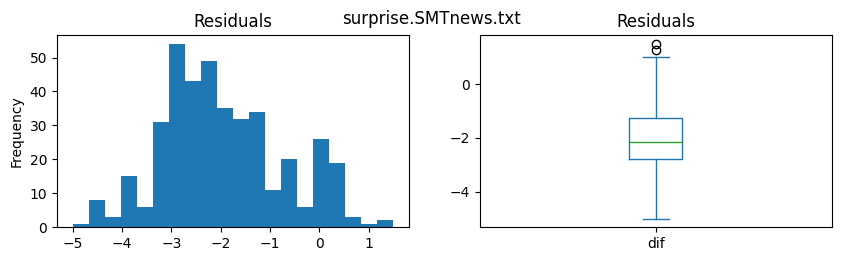

In [12]:
def clean_text(text):

    # Standardize the hours (1pm -> 13:00)
    def convert_to_24_hour(match):
        '''
        Function to convert time to 24 hour format
        Input: match - match object
        Output: string with the time in 24 hour format
        '''
        time_str = match.groups()
        hour, minute, am_pm = time_str[0], '' if time_str[1] is None else time_str[1] ,  re.sub('\.', '', '' if time_str[2] is None else time_str[2])
        # print(time_str)
        if am_pm == 'pm':
            if minute == '':
                return str(int(hour) + 12) + ':00'
            else:
                return str(int(hour) + 12) + ':' + minute
        elif am_pm == 'am':
            if hour == '12':
                return "00" + ':' + minute
            elif minute == '':
                return hour + ':00'
            else:
                return hour + ':' + minute
        else:
            if minute == '':
                return hour + ':00'
            else:
                return hour + ':' + minute

    hour_pattern_1 = re.compile(r'(?<=\s)(\d+)\s?()([ap]\.?m\.?)')
    hour_pattern_2 = re.compile(r'(\d+)[:\.](\d+)\s?([ap]\.?m\.?)')
    hour_pattern_3 = re.compile(r'(\d+)\s?[h:]\s?(\d+)\s?([ap]\.?m\.?)?')
    ls_patterns = [hour_pattern_1, hour_pattern_2, hour_pattern_3]
    for pat in ls_patterns:
        text = re.sub(pat, convert_to_24_hour, text)

    # Delete rests of abbreviated particles
    particle_pattern = re.compile(r"\b(?:'s|'d|'ll|'m|'re|'ve)\b", re.IGNORECASE)
    formatted_text = re.sub(particle_pattern, '', text)

    # Delete rests of abbreviated words to refer people
    mr_ms_pattern = re.compile(r"\b(mr.|mr|ms|ms.|mss.)\b", re.IGNORECASE)
    formatted_text = re.sub(mr_ms_pattern, '', formatted_text)

    # Convert indexes to a single word
    idx_pattern = re.compile(r'<\W*(\w+)=*(\w*)>', re.IGNORECASE)
    formatted_text = re.sub(idx_pattern, r'\1\2', formatted_text)
    
    # Remove the point from words starting with it
    start_point_pattern = re.compile(r'(\W)\.(\w+)', re.IGNORECASE)
    formatted_text = re.sub(start_point_pattern, r'\2', formatted_text)

    # Remove the comma from thousands (standardize)
    thousands_pattern = re.compile(r'(\d+),(\d+)', re.IGNORECASE)
    formatted_text = re.sub(thousands_pattern, r'\1\2', formatted_text)

    # Transform percentages to a single word
    percent_pattern = re.compile(r'(\d+)\s*per\s*cent', re.IGNORECASE)
    formatted_text = re.sub(percent_pattern, r'\1_%', formatted_text)
    
    # Remove the dollar sign from money
    money_pattern = re.compile(r'\$', re.IGNORECASE)
    formatted_text = re.sub(money_pattern, '' , formatted_text)

    return formatted_text


def spacy_ner_replace_porter(text, sw_lang='english', out_set=False, clean_func=None):
    '''
    Function to preprocess the text - remove punctuations, convert to lowercase, remove stopwords
    Input: text - string
    Output: ls_processed_text - list of words
    '''

    if clean_func is not None:
        text = clean_func(text)

    # text = clean_text(text)
    doc = nlp(text)
    with doc.retokenize() as retokenizer:
        tokens = [token for token in doc]
        for ent in doc.ents:
            retokenizer.merge(doc[ent.start:ent.end], 
                attrs={"LEMMA": " ".join([tokens[i].text 
                                    for i in range(ent.start, ent.end)])})

    stemmer = PorterStemmer()
    ls_processed_text = [stemmer.stem(w.lemma_.lower()) if len(w.text.split()) == 1 else w.ent_type_ 
                         for w in doc if not w.is_stop and not w.is_punct]

    if out_set:
        # For distance metrics, usually, it's needed a set of words
        return set(ls_processed_text)
    else:
        return ls_processed_text
    
def spacy_ner_replace_porter_clean(x, **kwargs): return spacy_ner_replace_porter(x, clean_func=clean_text, **kwargs)

ls_files = ["MSRpar.txt", "MSRvid.txt", "SMTeuroparl.txt", "surprise.OnWN.txt", "surprise.SMTnews.txt"]

lemma_ner_replace_porter_clean = STSAnalyzer(spacy_ner_replace_porter_clean, name='Lemma+NER+Replace+Porter+Clean')
lemma_ner_replace_porter_clean.col_report(ls_files, n_show=20)
lemma_ner_replace_porter_clean.corr_table(ls_files)

In [13]:
lemma_ner_replace_porter_clean.df_global_scores

,all,allnorm,wmean,name
0,0.598226,0.809345,0.592995,Lemma+NER+Replace+Porter+Clean


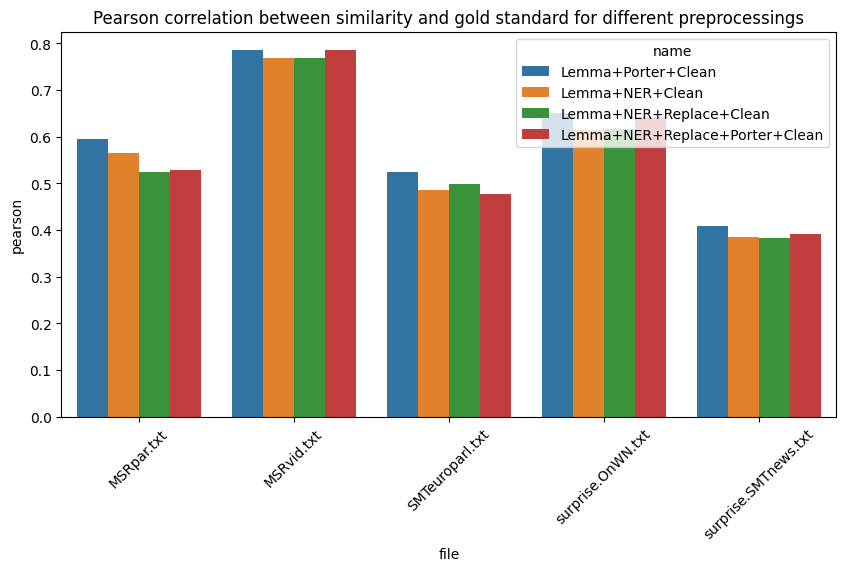

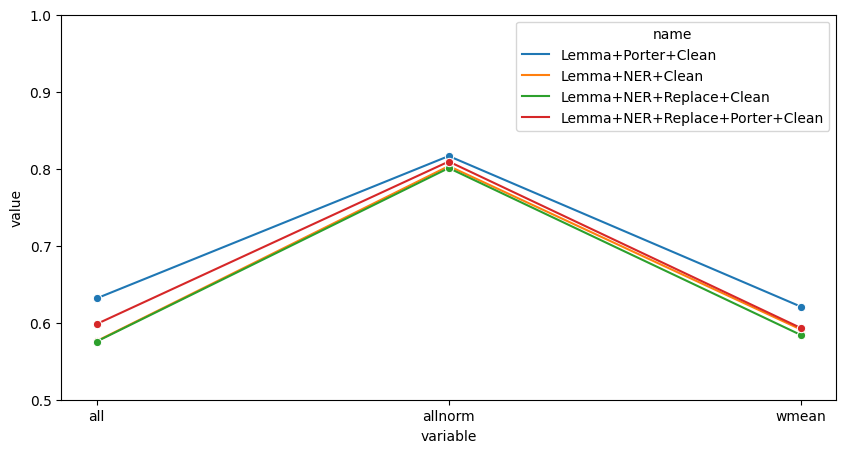

In [14]:
lemma_porter_clean.plot_col_analysis([lemma_ner_clean, lemma_ner_replace_clean, lemma_ner_replace_porter_clean])

In [17]:
df_total = pd.concat([lemma_porter_clean.df_global_scores, lemma_ner_clean.df_global_scores,
                        lemma_ner_replace_clean.df_global_scores, lemma_ner_replace_porter_clean.df_global_scores], axis=0)

df_total

,all,allnorm,wmean,name
0,0.631572,0.816485,0.620748,Lemma+Porter+Clean
0,0.576005,0.803465,0.591085,Lemma+NER+Clean
0,0.575486,0.800897,0.583946,Lemma+NER+Replace+Clean
0,0.598226,0.809345,0.592995,Lemma+NER+Replace+Porter+Clean


# Results and Conclussions

No improvement is achieved in general.

- The best performing option is the one that uses the NER based tokenization and replaces the words with the NER label. Applying the Porter Stemming algorithm to the words improve the results. This is because it standardizes better the text in the cases where the NER module doesn't identify the entity.

- Entity recognition algorithm is not perfect. It is not able to identify all the entities in the text. This is the reason why the results are not better than the baseline.

e.g: In the following example it is not able to identify the entity "The Turkish Government" as a single entity just because government is not capitalized.

```
Indeed, intolerance goes right to the top of the Turkish government. 
 It is undeniable that intolerance reached until the meetings the Turkish Government.

PREPROCESSED TEXT
{'intolerance', 'right', 'government', 'go', 'turkish'} 
 {'intolerance', 'undeniable', 'reach', 'the turkish government', 'meeting'}
INTERSECTION {'intolerance'}
DIFFERENCE {'undeniable', 'right', 'reach', 'the turkish government', 'government', 'turkish', 'go', 'meeting'}
```

The strategies used in this work are not able to solve this problem. The main reasons are:

- Retokenization Strategy: Even if sometimes it is capable of identifying the entity and group them, the possibilities of both "multiword tokens" to be equal are much lesser than with single tokens.
- Replace by NER label: This strategy is much more aggressive than the previous one. However, it is not able to identify the entity in most of the cases. In addition to that, if for example, two different people are identified in the text, they will be replaced by the same label.


# Further Work

- Try to combine handcrafted rules with the NER module in order to improve the results. For example, identifying all the dates and extracting the year from them.
- Get the intersection of the words of the same entity in order to improve the results.